# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "Manual_RYZEN3b" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/CATB/Tuning/Manual/RYZEN3b_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/CATB/Tuning/Manual/RYZEN3b_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'gpu_cat_features_storage': 'CpuPinnedMemory', 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 3, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 1000, 'objective': 'Logloss', 'task_type': 'GPU'}

Parsed IB Hyperparams: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'gpu_cat_features_storage': 'CpuPinnedMemory', 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 1000, 'objective': 'Logloss', 'task_type': 'GPU'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72298, 101)
IB Train Size: (72298, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryInfoKeyW,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW
2,1,GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,...,GetSystemInfo,NtClose,NtUnmapViewOfSection,NtClose,RegOpenKeyExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtOpenFile
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtCreateMutant,GetNativeSystemInfo,GetSystemWindowsDirectoryW,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,GetSystemTimeAsFileTime,NtCreateMutant,NtOpenKeyEx,NtQueryKey,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumKeyExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                           nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                       nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.3007719	test: 0.3014467	best: 0.3014467 (0)	total: 252ms	remaining: 4m 11s
1:	total: 443ms	remaining: 3m 40s
2:	total: 620ms	remaining: 3m 26s
3:	total: 794ms	remaining: 3m 17s
4:	total: 964ms	remaining: 3m 11s
5:	learn: 0.0386523	test: 0.0417992	best: 0.0417992 (5)	total: 1.14s	remaining: 3m 9s
6:	total: 1.31s	remaining: 3m 6s
7:	total: 1.48s	remaining: 3m 3s
8:	total: 1.64s	remaining: 3m
9:	total: 1.8s	remaining: 2m 58s
10:	learn: 0.0280901	test: 0.0316018	best: 0.0316018 (10)	total: 1.97s	remaining: 2m 57s
11:	total: 2.14s	remaining: 2m 56s
12:	total: 2.31s	remaining: 2m 55s
13:	total: 2.47s	remaining: 2m 53s
14:	total: 2.63s	remaining: 2m 52s
15:	learn: 0.0260345	test: 0.0301064	best: 0.0301064 (15)	total: 2.8s	remaining: 2m 51s
16:	total: 2.96s	remaining: 2m 51s
17:	total: 3.13s	remaining: 2m 50s
18:	total: 3.29s	remaining: 2m 49s
19:	total: 3.45s	remaining: 2m 48s
20:	learn: 0.0248359	test: 0.0291443	best: 0.0291443 (20)	total: 3.62s	remaining: 2m 48s
21:	total: 3.78s

178:	total: 29.5s	remaining: 2m 15s
179:	total: 29.6s	remaining: 2m 14s
180:	learn: 0.0130371	test: 0.0216399	best: 0.0216399 (180)	total: 29.8s	remaining: 2m 14s
181:	total: 30s	remaining: 2m 14s
182:	total: 30.1s	remaining: 2m 14s
183:	total: 30.3s	remaining: 2m 14s
184:	total: 30.4s	remaining: 2m 14s
185:	learn: 0.0129937	test: 0.0216136	best: 0.0216136 (185)	total: 30.6s	remaining: 2m 13s
186:	total: 30.8s	remaining: 2m 13s
187:	total: 30.9s	remaining: 2m 13s
188:	total: 31.1s	remaining: 2m 13s
189:	total: 31.3s	remaining: 2m 13s
190:	learn: 0.0128667	test: 0.0215037	best: 0.0215037 (190)	total: 31.4s	remaining: 2m 13s
191:	total: 31.6s	remaining: 2m 12s
192:	total: 31.7s	remaining: 2m 12s
193:	total: 31.9s	remaining: 2m 12s
194:	total: 32.1s	remaining: 2m 12s
195:	learn: 0.0128539	test: 0.0215036	best: 0.0215036 (195)	total: 32.2s	remaining: 2m 12s
196:	total: 32.4s	remaining: 2m 12s
197:	total: 32.6s	remaining: 2m 11s
198:	total: 32.7s	remaining: 2m 11s
199:	total: 32.9s	remainin

356:	total: 58.6s	remaining: 1m 45s
357:	total: 58.8s	remaining: 1m 45s
358:	total: 58.9s	remaining: 1m 45s
359:	total: 59.1s	remaining: 1m 45s
360:	learn: 0.0111829	test: 0.0207317	best: 0.0207297 (315)	total: 59.3s	remaining: 1m 44s
361:	total: 59.4s	remaining: 1m 44s
362:	total: 59.6s	remaining: 1m 44s
363:	total: 59.7s	remaining: 1m 44s
364:	total: 59.9s	remaining: 1m 44s
365:	learn: 0.0111823	test: 0.0207338	best: 0.0207297 (315)	total: 1m	remaining: 1m 44s
366:	total: 1m	remaining: 1m 43s
367:	total: 1m	remaining: 1m 43s
368:	total: 1m	remaining: 1m 43s
369:	total: 1m	remaining: 1m 43s
370:	learn: 0.0111641	test: 0.0207236	best: 0.0207236 (370)	total: 1m	remaining: 1m 43s
371:	total: 1m 1s	remaining: 1m 43s
372:	total: 1m 1s	remaining: 1m 42s
373:	total: 1m 1s	remaining: 1m 42s
374:	total: 1m 1s	remaining: 1m 42s
375:	learn: 0.0111608	test: 0.0207243	best: 0.0207236 (370)	total: 1m 1s	remaining: 1m 42s
376:	total: 1m 1s	remaining: 1m 42s
377:	total: 1m 2s	remaining: 1m 42s
378:	t

530:	learn: 0.0098312	test: 0.0201818	best: 0.0201718 (505)	total: 1m 27s	remaining: 1m 16s
531:	total: 1m 27s	remaining: 1m 16s
532:	total: 1m 27s	remaining: 1m 16s
533:	total: 1m 27s	remaining: 1m 16s
534:	total: 1m 27s	remaining: 1m 16s
535:	learn: 0.0098308	test: 0.0201841	best: 0.0201718 (505)	total: 1m 27s	remaining: 1m 16s
536:	total: 1m 28s	remaining: 1m 15s
537:	total: 1m 28s	remaining: 1m 15s
538:	total: 1m 28s	remaining: 1m 15s
539:	total: 1m 28s	remaining: 1m 15s
540:	learn: 0.0098305	test: 0.0201862	best: 0.0201718 (505)	total: 1m 28s	remaining: 1m 15s
541:	total: 1m 28s	remaining: 1m 15s
542:	total: 1m 29s	remaining: 1m 14s
543:	total: 1m 29s	remaining: 1m 14s
544:	total: 1m 29s	remaining: 1m 14s
545:	learn: 0.0097780	test: 0.0201839	best: 0.0201718 (505)	total: 1m 29s	remaining: 1m 14s
546:	total: 1m 29s	remaining: 1m 14s
547:	total: 1m 29s	remaining: 1m 14s
548:	total: 1m 30s	remaining: 1m 13s
549:	total: 1m 30s	remaining: 1m 13s
550:	learn: 0.0097503	test: 0.0201566	be

705:	learn: 0.0094478	test: 0.0201085	best: 0.0200683 (620)	total: 1m 55s	remaining: 48.2s
706:	total: 1m 55s	remaining: 48s
707:	total: 1m 56s	remaining: 47.9s
708:	total: 1m 56s	remaining: 47.7s
709:	total: 1m 56s	remaining: 47.6s
710:	learn: 0.0094471	test: 0.0201114	best: 0.0200683 (620)	total: 1m 56s	remaining: 47.4s
711:	total: 1m 56s	remaining: 47.2s
712:	total: 1m 56s	remaining: 47.1s
713:	total: 1m 57s	remaining: 46.9s
714:	total: 1m 57s	remaining: 46.7s
715:	learn: 0.0094395	test: 0.0201222	best: 0.0200683 (620)	total: 1m 57s	remaining: 46.6s
716:	total: 1m 57s	remaining: 46.4s
717:	total: 1m 57s	remaining: 46.2s
718:	total: 1m 57s	remaining: 46.1s
719:	total: 1m 58s	remaining: 45.9s
720:	learn: 0.0094390	test: 0.0201283	best: 0.0200683 (620)	total: 1m 58s	remaining: 45.8s
721:	total: 1m 58s	remaining: 45.6s
722:	total: 1m 58s	remaining: 45.4s
723:	total: 1m 58s	remaining: 45.3s
724:	total: 1m 58s	remaining: 45.1s
725:	learn: 0.0094363	test: 0.0201174	best: 0.0200683 (620)	to

881:	total: 2m 24s	remaining: 19.4s
882:	total: 2m 24s	remaining: 19.2s
883:	total: 2m 25s	remaining: 19s
884:	total: 2m 25s	remaining: 18.9s
885:	learn: 0.0090383	test: 0.0199694	best: 0.0199603 (825)	total: 2m 25s	remaining: 18.7s
886:	total: 2m 25s	remaining: 18.5s
887:	total: 2m 25s	remaining: 18.4s
888:	total: 2m 25s	remaining: 18.2s
889:	total: 2m 25s	remaining: 18s
890:	learn: 0.0090371	test: 0.0199743	best: 0.0199603 (825)	total: 2m 26s	remaining: 17.9s
891:	total: 2m 26s	remaining: 17.7s
892:	total: 2m 26s	remaining: 17.6s
893:	total: 2m 26s	remaining: 17.4s
894:	total: 2m 26s	remaining: 17.2s
895:	learn: 0.0090361	test: 0.0199798	best: 0.0199603 (825)	total: 2m 26s	remaining: 17.1s
896:	total: 2m 27s	remaining: 16.9s
897:	total: 2m 27s	remaining: 16.7s
898:	total: 2m 27s	remaining: 16.6s
899:	total: 2m 27s	remaining: 16.4s
900:	learn: 0.0090361	test: 0.0199814	best: 0.0199603 (825)	total: 2m 27s	remaining: 16.2s
901:	total: 2m 27s	remaining: 16.1s
902:	total: 2m 28s	remaining

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_TB
              precision    recall  f1-score   support

           0     0.9983    0.9917    0.9950     10842
           1     0.9918    0.9983    0.9950     10848

    accuracy                         0.9950     21690
   macro avg     0.9950    0.9950    0.9950     21690
weighted avg     0.9950    0.9950    0.9950     21690

AUC-ROC: 0.9950198282490414


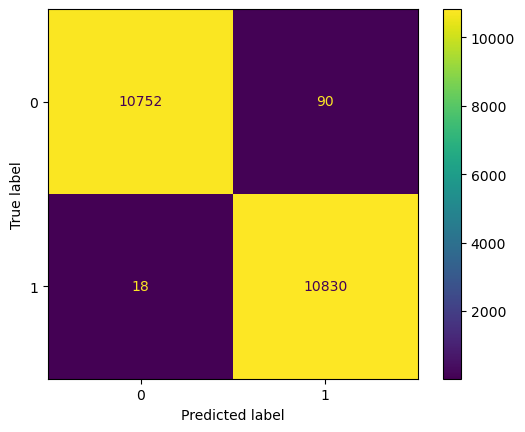

In [11]:
y_pred = tb_catb.predict(X_tb_validate)
print("CATB_TB")
print(classification_report(y_tb_validate, y_pred, digits=4))
print("AUC-ROC:", roc_auc_score(y_tb_validate, y_pred))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
print("AUC-ROC:", roc_auc_score(y_tb_validate, y_pred), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='a'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

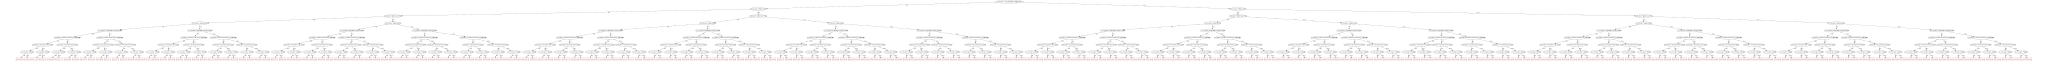

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree"+".svg")
display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.1695079	test: 0.1723084	best: 0.1723084 (0)	total: 511ms	remaining: 8m 30s
1:	total: 950ms	remaining: 7m 53s
2:	total: 1.38s	remaining: 7m 39s
3:	total: 1.81s	remaining: 7m 31s
4:	total: 2.24s	remaining: 7m 25s
5:	learn: 0.0261391	test: 0.0298264	best: 0.0298264 (5)	total: 2.67s	remaining: 7m 22s
6:	total: 3.1s	remaining: 7m 19s
7:	total: 3.53s	remaining: 7m 17s
8:	total: 3.96s	remaining: 7m 16s
9:	total: 4.39s	remaining: 7m 14s
10:	learn: 0.0214620	test: 0.0269966	best: 0.0269966 (10)	total: 4.82s	remaining: 7m 13s
11:	total: 5.24s	remaining: 7m 11s
12:	total: 5.67s	remaining: 7m 10s
13:	total: 6.1s	remaining: 7m 9s
14:	total: 6.52s	remaining: 7m 8s
15:	learn: 0.0204921	test: 0.0267865	best: 0.0267865 (15)	total: 6.95s	remaining: 7m 7s
16:	total: 7.37s	remaining: 7m 6s
17:	total: 7.8s	remaining: 7m 5s
18:	total: 8.22s	remaining: 7m 4s
19:	total: 8.65s	remaining: 7m 4s
20:	learn: 0.0182053	test: 0.0258633	best: 0.0258633 (20)	total: 9.09s	remaining: 7m 3s
21:	total: 9.52s	r

179:	total: 1m 17s	remaining: 5m 50s
180:	learn: 0.0125955	test: 0.0233188	best: 0.0231351 (160)	total: 1m 17s	remaining: 5m 50s
181:	total: 1m 17s	remaining: 5m 50s
182:	total: 1m 18s	remaining: 5m 49s
183:	total: 1m 18s	remaining: 5m 49s
184:	total: 1m 19s	remaining: 5m 48s
185:	learn: 0.0123982	test: 0.0231911	best: 0.0231351 (160)	total: 1m 19s	remaining: 5m 48s
186:	total: 1m 20s	remaining: 5m 47s
187:	total: 1m 20s	remaining: 5m 47s
188:	total: 1m 20s	remaining: 5m 46s
189:	total: 1m 21s	remaining: 5m 46s
190:	learn: 0.0123158	test: 0.0231659	best: 0.0231351 (160)	total: 1m 21s	remaining: 5m 46s
191:	total: 1m 22s	remaining: 5m 45s
192:	total: 1m 22s	remaining: 5m 45s
193:	total: 1m 22s	remaining: 5m 44s
194:	total: 1m 23s	remaining: 5m 44s
195:	learn: 0.0121981	test: 0.0231141	best: 0.0231141 (195)	total: 1m 23s	remaining: 5m 43s
196:	total: 1m 24s	remaining: 5m 43s
197:	total: 1m 24s	remaining: 5m 43s
198:	total: 1m 25s	remaining: 5m 42s
199:	total: 1m 25s	remaining: 5m 42s
200

351:	total: 2m 30s	remaining: 4m 37s
352:	total: 2m 31s	remaining: 4m 36s
353:	total: 2m 31s	remaining: 4m 36s
354:	total: 2m 31s	remaining: 4m 36s
355:	learn: 0.0106812	test: 0.0227291	best: 0.0226954 (325)	total: 2m 32s	remaining: 4m 35s
356:	total: 2m 32s	remaining: 4m 35s
357:	total: 2m 33s	remaining: 4m 34s
358:	total: 2m 33s	remaining: 4m 34s
359:	total: 2m 34s	remaining: 4m 34s
360:	learn: 0.0106796	test: 0.0227347	best: 0.0226954 (325)	total: 2m 34s	remaining: 4m 33s
361:	total: 2m 35s	remaining: 4m 33s
362:	total: 2m 35s	remaining: 4m 32s
363:	total: 2m 35s	remaining: 4m 32s
364:	total: 2m 36s	remaining: 4m 31s
365:	learn: 0.0105895	test: 0.0228046	best: 0.0226954 (325)	total: 2m 36s	remaining: 4m 31s
366:	total: 2m 37s	remaining: 4m 31s
367:	total: 2m 37s	remaining: 4m 30s
368:	total: 2m 38s	remaining: 4m 30s
369:	total: 2m 38s	remaining: 4m 29s
370:	learn: 0.0105892	test: 0.0228096	best: 0.0226954 (325)	total: 2m 38s	remaining: 4m 29s
371:	total: 2m 39s	remaining: 4m 28s
372

524:	total: 3m 44s	remaining: 3m 23s
525:	learn: 0.0085562	test: 0.0222330	best: 0.0221953 (475)	total: 3m 45s	remaining: 3m 22s
526:	total: 3m 45s	remaining: 3m 22s
527:	total: 3m 46s	remaining: 3m 22s
528:	total: 3m 46s	remaining: 3m 21s
529:	total: 3m 46s	remaining: 3m 21s
530:	learn: 0.0085548	test: 0.0222356	best: 0.0221953 (475)	total: 3m 47s	remaining: 3m 20s
531:	total: 3m 47s	remaining: 3m 20s
532:	total: 3m 48s	remaining: 3m 19s
533:	total: 3m 48s	remaining: 3m 19s
534:	total: 3m 49s	remaining: 3m 19s
535:	learn: 0.0085540	test: 0.0222387	best: 0.0221953 (475)	total: 3m 49s	remaining: 3m 18s
536:	total: 3m 49s	remaining: 3m 18s
537:	total: 3m 50s	remaining: 3m 17s
538:	total: 3m 50s	remaining: 3m 17s
539:	total: 3m 51s	remaining: 3m 16s
540:	learn: 0.0085533	test: 0.0222437	best: 0.0221953 (475)	total: 3m 51s	remaining: 3m 16s
541:	total: 3m 52s	remaining: 3m 16s
542:	total: 3m 52s	remaining: 3m 15s
543:	total: 3m 52s	remaining: 3m 15s
544:	total: 3m 53s	remaining: 3m 14s
545

696:	total: 4m 58s	remaining: 2m 9s
697:	total: 4m 58s	remaining: 2m 9s
698:	total: 4m 59s	remaining: 2m 8s
699:	total: 4m 59s	remaining: 2m 8s
700:	learn: 0.0081036	test: 0.0222602	best: 0.0221942 (610)	total: 5m	remaining: 2m 8s
701:	total: 5m	remaining: 2m 7s
702:	total: 5m 1s	remaining: 2m 7s
703:	total: 5m 1s	remaining: 2m 6s
704:	total: 5m 1s	remaining: 2m 6s
705:	learn: 0.0081034	test: 0.0222614	best: 0.0221942 (610)	total: 5m 2s	remaining: 2m 5s
706:	total: 5m 2s	remaining: 2m 5s
707:	total: 5m 3s	remaining: 2m 5s
708:	total: 5m 3s	remaining: 2m 4s
709:	total: 5m 4s	remaining: 2m 4s
710:	learn: 0.0081020	test: 0.0222722	best: 0.0221942 (610)	total: 5m 4s	remaining: 2m 3s
711:	total: 5m 4s	remaining: 2m 3s
712:	total: 5m 5s	remaining: 2m 2s
713:	total: 5m 5s	remaining: 2m 2s
714:	total: 5m 6s	remaining: 2m 2s
715:	learn: 0.0081016	test: 0.0222703	best: 0.0221942 (610)	total: 5m 6s	remaining: 2m 1s
716:	total: 5m 7s	remaining: 2m 1s
717:	total: 5m 7s	remaining: 2m
718:	total: 5m 

871:	total: 6m 13s	remaining: 54.9s
872:	total: 6m 14s	remaining: 54.5s
873:	total: 6m 15s	remaining: 54.1s
874:	total: 6m 15s	remaining: 53.6s
875:	learn: 0.0073872	test: 0.0221271	best: 0.0220713 (835)	total: 6m 15s	remaining: 53.2s
876:	total: 6m 16s	remaining: 52.8s
877:	total: 6m 16s	remaining: 52.4s
878:	total: 6m 17s	remaining: 51.9s
879:	total: 6m 17s	remaining: 51.5s
880:	learn: 0.0073870	test: 0.0221284	best: 0.0220713 (835)	total: 6m 18s	remaining: 51.1s
881:	total: 6m 18s	remaining: 50.6s
882:	total: 6m 19s	remaining: 50.3s
883:	total: 6m 19s	remaining: 49.8s
884:	total: 6m 20s	remaining: 49.4s
885:	learn: 0.0073870	test: 0.0221287	best: 0.0220713 (835)	total: 6m 20s	remaining: 49s
886:	total: 6m 21s	remaining: 48.5s
887:	total: 6m 21s	remaining: 48.1s
888:	total: 6m 21s	remaining: 47.7s
889:	total: 6m 22s	remaining: 47.3s
890:	learn: 0.0073868	test: 0.0221318	best: 0.0220713 (835)	total: 6m 22s	remaining: 46.8s
891:	total: 6m 23s	remaining: 46.4s
892:	total: 6m 23s	remaini

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_IB
              precision    recall  f1-score   support

           0     0.9979    0.9919    0.9949     10842
           1     0.9919    0.9979    0.9949     10848

    accuracy                         0.9949     21690
   macro avg     0.9949    0.9949    0.9949     21690
weighted avg     0.9949    0.9949    0.9949     21690

AUC-ROC: 0.9948816049270862


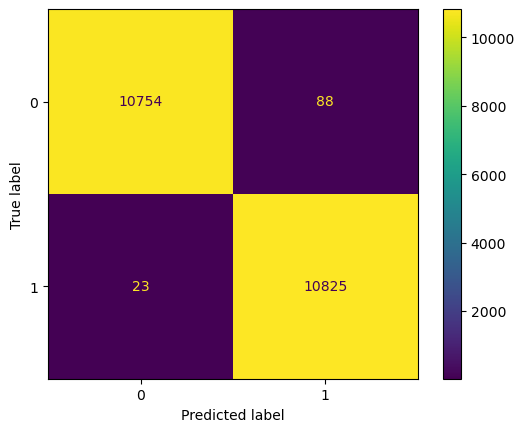

In [14]:
y_pred = ib_catb.predict(X_ib_validate)
print("CATB_IB")
print(classification_report(y_ib_validate, y_pred, digits=4))
print("AUC-ROC:", roc_auc_score(y_ib_validate, y_pred))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
print("AUC-ROC:", roc_auc_score(y_ib_validate, y_pred), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='a'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [15]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree"+".svg")
tree

In [16]:
logging("\n")